# Imports


In [1]:
import sys
sys.path.append("../lib")
import imageio.v2 as imageio
import os
import shutil
import em2d as zpic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import math
from IPython.display import Video
matplotlib.rcParams["figure.figsize"] = (12, 8)

# Noramalization in ZPIC


The normalization in ZPIC is done by choosing a reference normalization frequency, $\omega_n$. Using this, different units are noramlized by the formulae:

$$
\begin{align*}
x' &= \frac{\omega_n}{c} x\\
t' &= \frac{t}{\omega_n}\\
u' &= \frac{u}{c} = \frac{\gamma v}{c}\\
E' &= e \frac{c / \omega_n }{m_e c^2} E\\
B' &= e \frac{c / \omega_n }{m_e c^2} B
\end{align*}
$$


In the simulation, we will choose $\omega_n$ such as the plasma density is eqaul to $1$. This can be done by using the relation of plasma density:

$$
\omega_p = \sqrt{\frac{n_0e^2}{\epsilon_0 m}}
$$

Which simplifies to:

$$
\omega_p = 56.35\times \sqrt{n_0}
$$


# 6.1.1 Simulation of laser propagation in vacuum


## Parameters


### In Real Units


- Simulation Box: $20\:\mu m\times20\:\mu m\times50\:\mu m$
- Number of Cells: $200\times200\times500$
- Plasma Density: $n_0 = 10^{25} \: m^{-3}$
- Laser Intensity: $I = 2\times10^{22} \: Wm^{-2}$
- Laser Wavelength: $\lambda = 10^{-6} \: m$
- Particle Per Cell: $0$
- FWHM of the Laser: $1 \:\mu m$
- Width of the Laser: $2.5 \:\mu m$
- The laser propagates in z direction and is p-polarized, that is, the electric field vector of the laser oscillates along the y-axis.
- The laser starts at $(10\:\mu m\times10\:\mu m\times-2\:\mu m)$ which is the center of the xy-plane $2 \:\mu m$ in front of the
  simulation box.


### In Simulation Units


As $n_0=10^{25} \: m^{-3}$, the electron plasma frequency corresponding to this is

$$
\begin{align*}
\omega_n &= 56.35\times \sqrt{10^{25}} \: \mathrm{Hz}\\
&= 1.78\times 10^{14} \: \mathrm{Hz}
\end{align*}
$$


Using this we can calculate that $1 \:\mu m$ is equal to $0.593 \: \text{zpic unit}$


Now, the electric field of the laser is can be calculated using:

$$
I = \frac{1}{2}\epsilon_0 c E_0^2
$$

The electric field comes out to be $3.882\times 10^{12} \:\text{N/C}$. Noramlizing this to ZPIC unit gives a value of $12.77$.


Next, we'll calculate the frequency of the laser using its wavelength. Since $f = \frac{c}{\lambda}$, the frequency is (after multiplying with $2\pi$) $1.88\times 10^{15} \:\text{Hz}$. In ZPIC units, this is equal to $10.6$.


The laser propagates in z direction and is p-polarized, however, ZPIC supports only those lasers moving in x direction. Hence, we'll be changing the axes such that:

z -> x

x -> y

y -> z


In this way, the laser in propagating in x direction while the electric field vector of the laser oscillates along the z-axis, making an angle of $\pi/2$ with y-axis.


The final units are:

- Simulation Box: $12 \times12 \times30$
- Number of Cells: $200\times200\times500$
- Plasma Density `n0`: $1$
- Particle Per Cell `ppc`: $0$
- Normalized vector potential `a0`: $12.77$
- Laser frequency `omega0` : $10.6$
- FWHM of the Laser `fwhm` : $0.593$
- Width of the Laser `W0`: $1.48$
- Laser polarization in radians measured in reference to the y direction `polarization`: $\pi/2$


## Simulation


In [2]:
wn = 1.78e14
tmax = 150*wn/10**15
tmax

26.7

The simulation will run till 150 fs, which, in zpic unit, translates to: $26.7$


In [3]:
((30/500)**2+(12/200)**2)**0.5

0.08485281374238571

In [4]:
box = [30.0, 12.0]
wn = 1.78e14
dt = 0.01
ppc = [0,0]
nx  = [ 500, 200 ]
tmax = 26.7
sim = zpic.Simulation( nx, box, dt)

In [5]:
laser = zpic.Laser( type = "gaussian", start = 1, fwhm = 0.593, a0 = 12.77, omega0 = 10.6, W0 = 1.48, polarization = np.pi/2 , axis=6)
sim.add_laser(laser)

In [6]:
tdump = 100
max_time = math.ceil(tmax/(dt*tdump))
ezs = np.zeros((max_time, nx[1], nx[0]))
eys = np.zeros((max_time, nx[1], nx[0]))
exs = np.zeros((max_time, nx[1], nx[0]))
times = ["1.00", "5.87", "8.40", "11.75", "17.80", "23.67"]
ezs_time = np.zeros((len(times), nx[1], nx[0]))

j = 0
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:
        ezs[t//tdump,:,:] = sim.emf.Ez
        eys[t//tdump,:,:] = sim.emf.Ey
        exs[t//tdump,:,:] = sim.emf.Ex
    if f"{t*dt:.2f}" in times:
        ezs_time[j,:,:] = sim.emf.Ez
        j += 1

In [7]:
time_new = np.linspace(0, tmax, max_time)/wn*1e15
time_new

array([  0.        ,   5.76923077,  11.53846154,  17.30769231,
        23.07692308,  28.84615385,  34.61538462,  40.38461538,
        46.15384615,  51.92307692,  57.69230769,  63.46153846,
        69.23076923,  75.        ,  80.76923077,  86.53846154,
        92.30769231,  98.07692308, 103.84615385, 109.61538462,
       115.38461538, 121.15384615, 126.92307692, 132.69230769,
       138.46153846, 144.23076923, 150.        ])

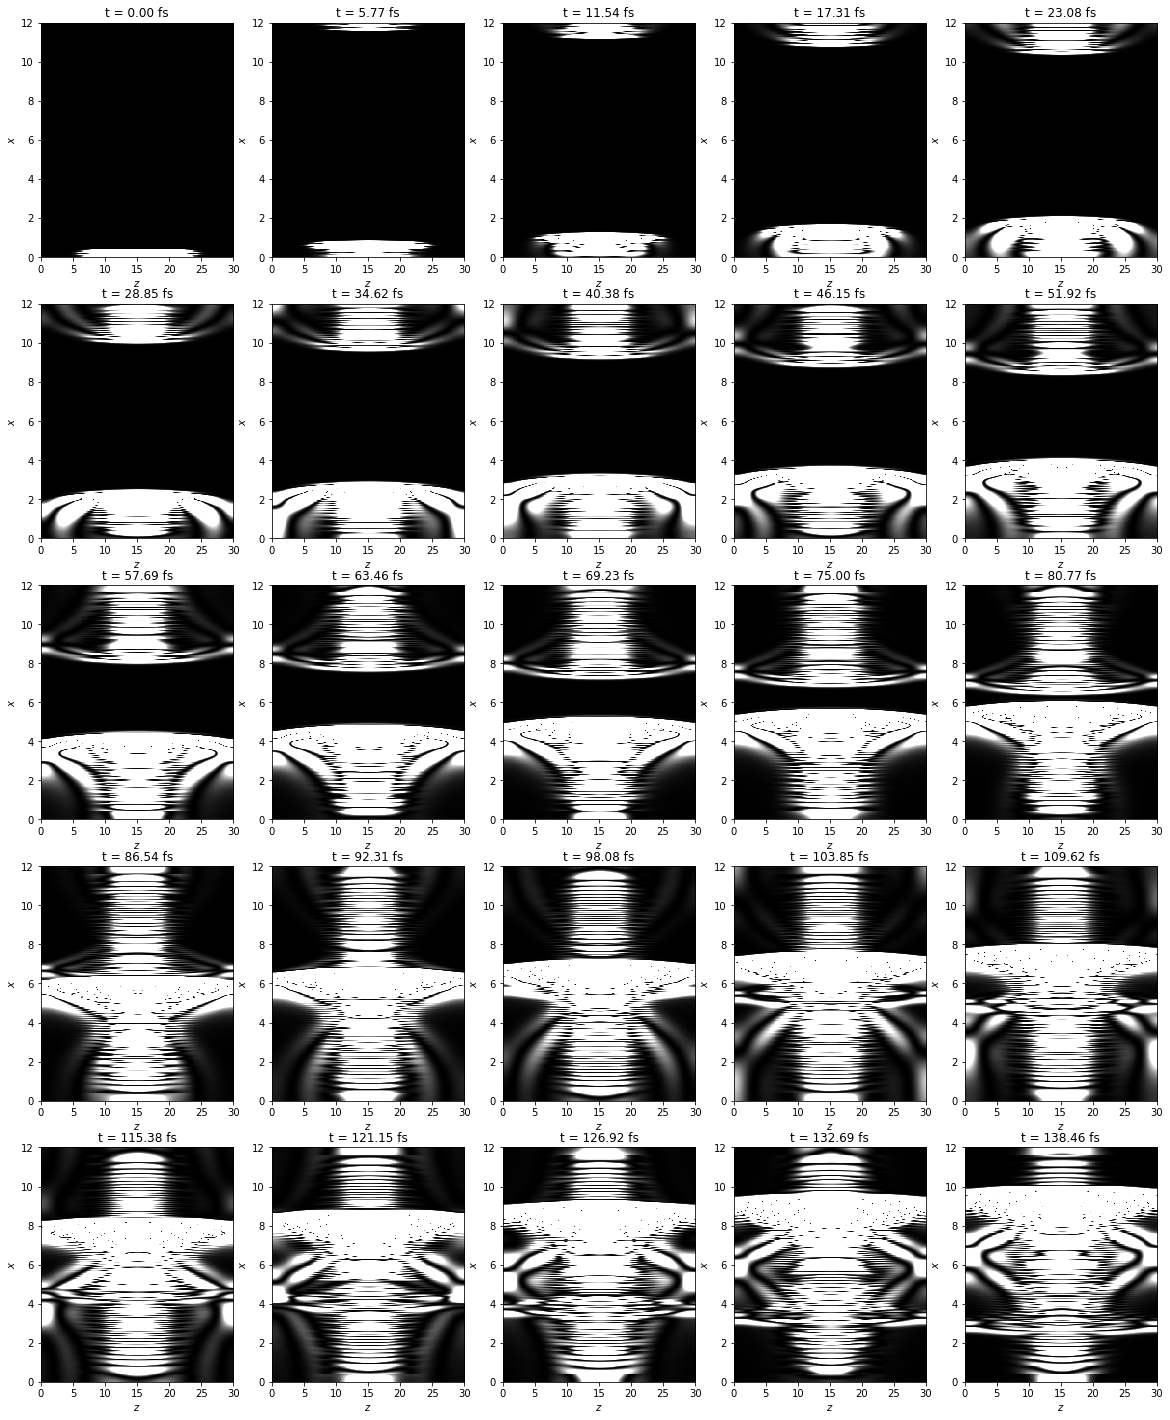

In [8]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(20,25)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( ezs[i].T**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray',
            norm=colors.Normalize(vmin=0.0, vmax=0.05)
            )
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
#     ax.axis('off')


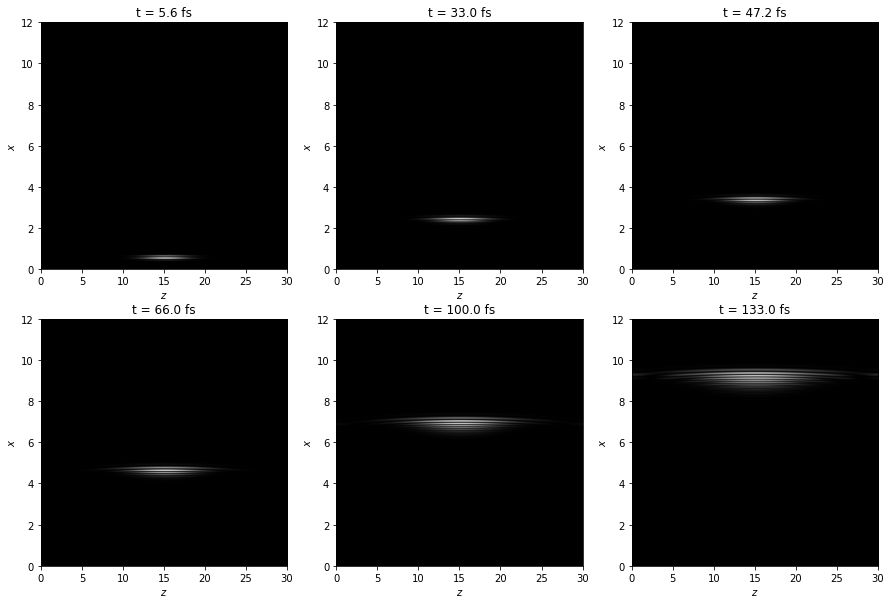

In [14]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,10)
times = ["1.00", "5.87", "8.40", "11.75", "17.80", "23.67"]
times = [float(t)/wn*1e15 for t in times]
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(6):
    row = i//3
    col = i%3
    ax = axs[row,col]
    ax.imshow( ezs_time[i].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {times[i]:.1f} fs")
#     ax.axis('off')


In [15]:
(ezs[0].max()**2+exs[0].max()**2+eys[0].max()**2)**0.5

105.37506103515639

In [16]:
def plot_for_time(time):
    boundary = [[0,sim.box[0]],[0,sim.box[1]]]

    plt.imshow( ezs_time[time].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')

    plt.colorbar().set_label('$E_z$')
    plt.xlabel("$z$")
    plt.ylabel("$x$")
    plt.title(f"Laser Field\nt = {times[time]}")

    plt.show()

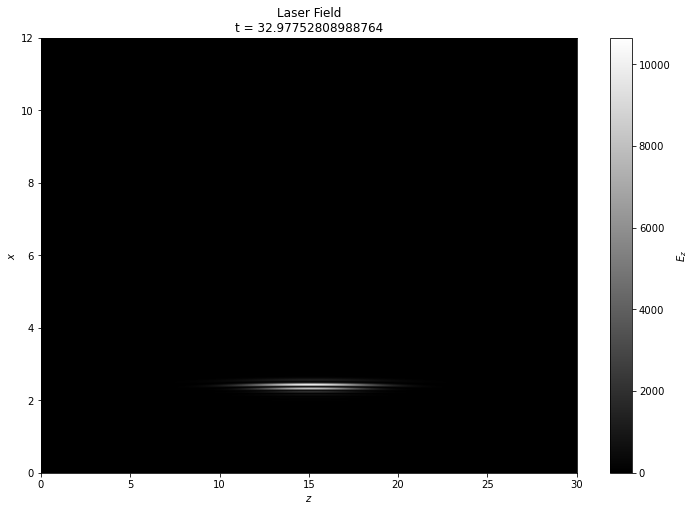

In [17]:
plot_for_time(1)

# 6.1.2 Simulations of relativistic self-focusing in 2D


## Parameters


### In Real Units


- Simulation Box: $40\:\mu m\times40\:\mu m\times50\:\mu m$
- Number of Cells: $400\times400\times1000$
- Plasma Density: $n_0 = 10^{26} \: m^{-3}$
- Laser Intensity: $I = 10^{23} \: Wm^{-2}$
- Laser Wavelength: $\lambda = 10^{-6} \: m$
- Particle Per Cell: $2$
- FWHM of the Laser: $1 \:\mu m$
- Width of the Laser: $5 \:\mu m$
- The laser propagates in z direction and is s-polarized, that is, the electric field vector of the laser oscillates in the x axis.
- The laser starts at $(20\:\mu m\times20\:\mu m\times-2\:\mu m)$ which is the center of the xy-plane $2 \:\mu m$ in front of the
  simulation box.


### In Simulation Units


As $n_0=10^{25} \: m^{-3}$, the electron plasma frequency corresponding to this is

$$
\begin{align*}
\omega_n &= 56.35\times \sqrt{10^{26}} \: \mathrm{Hz}\\
&= 5.635\times 10^{14} \: \mathrm{Hz}
\end{align*}
$$


Using this we can calculate that $1 \:\mu m$ is equal to $1.88 \: \text{zpic unit}$


Now, the electric field of the laser is can be calculated using:

$$
I = \frac{1}{2}\epsilon_0 c E_0^2
$$

The electric field comes out to be $8.680\times 10^{12} \:\text{N/C}$. Noramlizing this to ZPIC unit gives a value of $9.03$.


Next, we'll calculate the frequency of the laser using its wavelength. Since $f = \frac{c}{\lambda}$, the frequency is (after multiplying with $2\pi$) $1.88\times 10^{15} \:\text{Hz}$. In ZPIC units, this is equal to $3.345$.


The laser propagates in z direction and is s-polarized, however, ZPIC supports only those lasers moving in x direction. Hence, we'll be changing the axes such that:

z -> x

x -> y

y -> z


In this way, the laser in propagating in x direction while the electric field vector of the laser oscillates along the y-axis, making an angle of $0$ with y-axis.


The final units are:

- Simulation Box: $75 \times75 \times94$
- Number of Cells: $400\times400\times1000$
- Plasma Density `n0`: $1$
- Particle Per Cell `ppc`: $2$
- Normalized vector potential `a0`: $9.03$
- Laser frequency `omega0` : $3.345$
- FWHM of the Laser `fwhm` : $1.878$
- Width of the Laser `W0`: $9.39$
- Laser polarization in radians measured in reference to the y direction `polarization`: $0$


## Simulation


In [297]:
wn = 5.635e14

In [298]:
tmax = 140*wn/10**15
tmax

78.89

In [299]:
((75/400)**2+(94/1000)**2)**0.5

0.20974329548283538

The simulation will run till 140 fs, which, in zpic unit translates to: $78.89$


In [300]:
import sys
sys.path.append("../lib")
import em2d as zpic
box = [94.0, 75.0]
dt = 0.08
ppc = [2,2]
nx  = [ 1000, 400 ]
electrons = zpic.Species( "electrons", -1.0, ppc, density = zpic.Density( type = "uniform", n = 1 ) )
protons = zpic.Species( "protons", 1836, ppc, density = zpic.Density( type = "uniform", n = 1 ) )

sim = zpic.Simulation( nx, box, dt, species=[electrons, protons] )

In [301]:
laser = zpic.Laser( type = "gaussian", start = 1, fwhm = 1.878, a0 = 9.03, omega0 = 3.345, W0 = 9.39, polarization = 0, axis=37.5)
sim.add_laser( laser )

In [302]:
133*wn/1e15

74.9455

In [303]:
tdump = int(1/dt)*2
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
max_time = math.ceil(tmax/(dt*tdump))

ezs = np.zeros((max_time, nx[1], nx[0]))
eys = np.zeros((max_time, nx[1], nx[0]))
exs = np.zeros((max_time, nx[1], nx[0]))

rhoes = np.zeros((max_time, nx[1], nx[0]))
rhops = np.zeros((max_time, nx[1], nx[0]))

epyz = np.zeros((max_time, nx[1], nx[0]))
eppzy = np.zeros((max_time, nx[1], nx[0]))
eppzz = np.zeros((max_time, nx[1], nx[0]))

times = ["1.00", "6.20", "18.60", "37.19", "56.35", "74.95"]
ezs_time = np.zeros((len(times), nx[1], nx[0]))
eys_time = np.zeros((len(times), nx[1], nx[0]))
exs_time = np.zeros((len(times), nx[1], nx[0]))
j = 0
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:

        ezs[t//tdump,:,:] = sim.emf.Ez
        eys[t//tdump,:,:] = sim.emf.Ey
        exs[t//tdump,:,:] = sim.emf.Ex

        rhoes[t//tdump,:,:] = electrons.charge()
        rhops[t//tdump,:,:] = protons.charge()
        
        epyz[t//tdump,:,:] = electrons.phasespace(["x1", "x2"], nx, boundary )
        eppzy[t//tdump,:,:] = electrons.phasespace(["x1", "u1"], nx, boundary )
        eppzz[t//tdump,:,:] = electrons.phasespace(["x2", "u1"], nx, boundary )
        
    if f"{t*dt:.2f}" in times:
        # break
        ezs_time[j,:,:] = sim.emf.Ez
        eys_time[j,:,:] = sim.emf.Ey
        exs_time[j,:,:] = sim.emf.Ex
        j += 1

In [304]:
time_new = np.linspace(0, tmax, max_time)/wn*1e15
time_new

array([  0.        ,   3.41463415,   6.82926829,  10.24390244,
        13.65853659,  17.07317073,  20.48780488,  23.90243902,
        27.31707317,  30.73170732,  34.14634146,  37.56097561,
        40.97560976,  44.3902439 ,  47.80487805,  51.2195122 ,
        54.63414634,  58.04878049,  61.46341463,  64.87804878,
        68.29268293,  71.70731707,  75.12195122,  78.53658537,
        81.95121951,  85.36585366,  88.7804878 ,  92.19512195,
        95.6097561 ,  99.02439024, 102.43902439, 105.85365854,
       109.26829268, 112.68292683, 116.09756098, 119.51219512,
       122.92682927, 126.34146341, 129.75609756, 133.17073171,
       136.58536585, 140.        ])

In [305]:
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
boundary

[[0, 94.0], [0, 75.0]]

In [306]:
5e-5/3e8*1e15

166.66666666666669

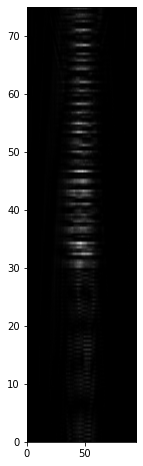

In [307]:
plt.imshow( eys[-1][:, 100:300].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect=5, 
            cmap = 'gray')

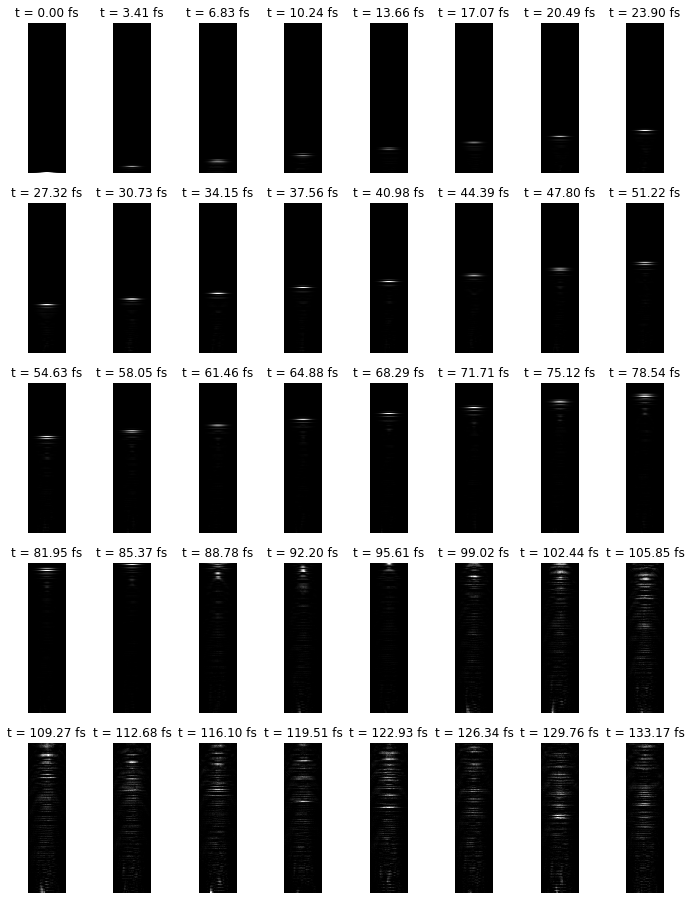

In [319]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( eys[i][100:300,0:500].T**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect=5, 
            cmap = 'gray')
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')


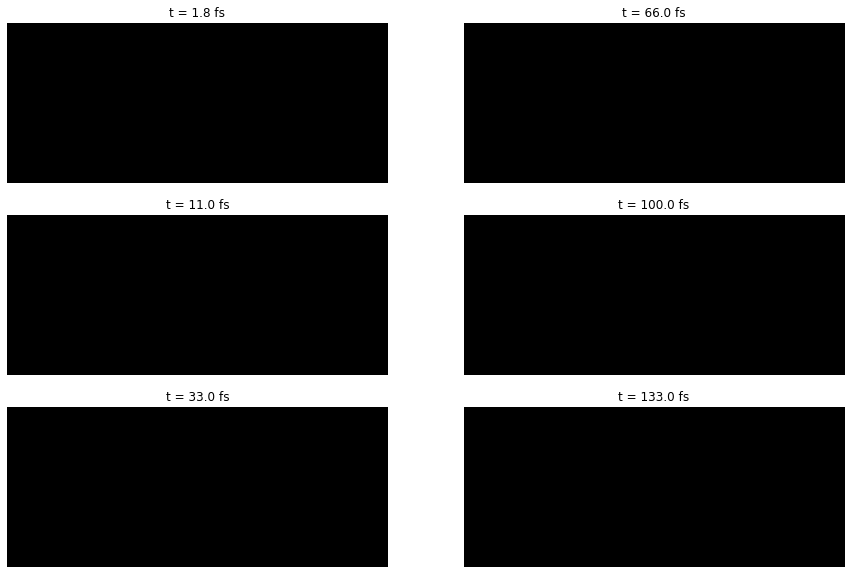

In [141]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(15,10)
times = ["1.00", "6.20", "18.60", "37.19", "56.35", "74.95"]
times = [float(t)/wn*1e15 for t in times]
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(6):
    row = i//3
    col = i%3
    ax = axs[col,row]
    ax.imshow( eys_time[i].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {times[i]:.1f} fs")
    ax.axis('off')


In [313]:
rhoes[-1].max(), rhoes[-1].min()

(0.0, -4.070669174194336)

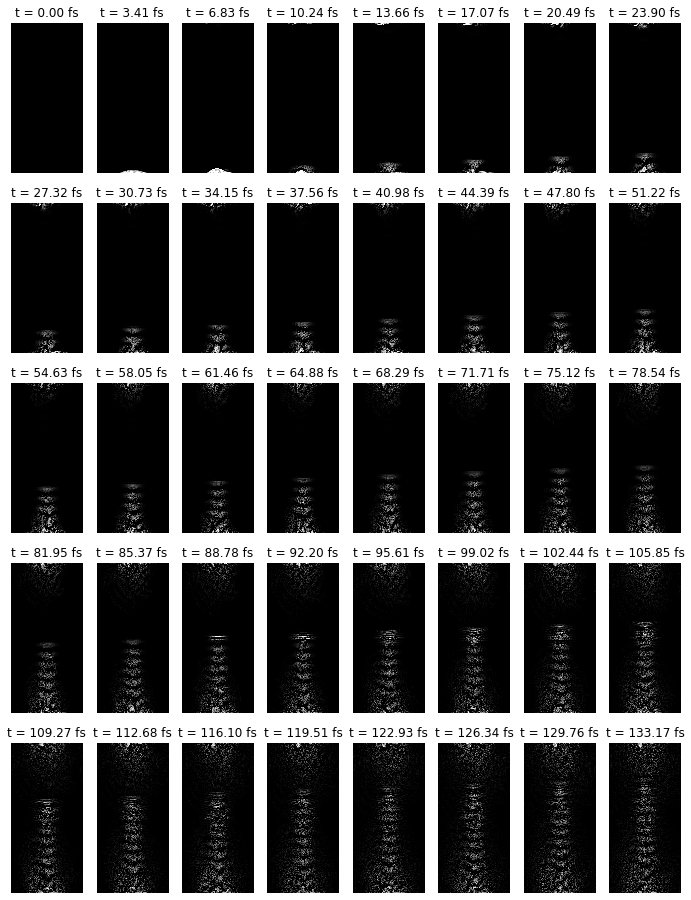

In [350]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( rhoes[i].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=-1, vmax=-0.002)
            )
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')

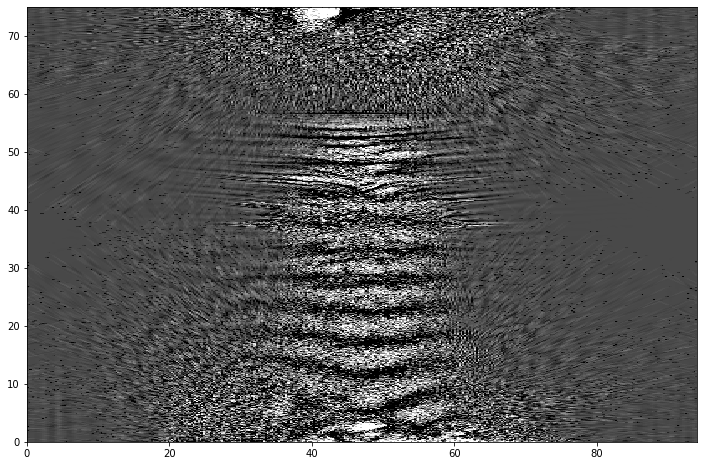

In [383]:
plt.imshow( rhoes[38].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=-1.2, vmax=-0.5)
            )

In [340]:
rhops[0].min(), rhops[0].max()

(0.9999898076057434, 1.0000100135803223)

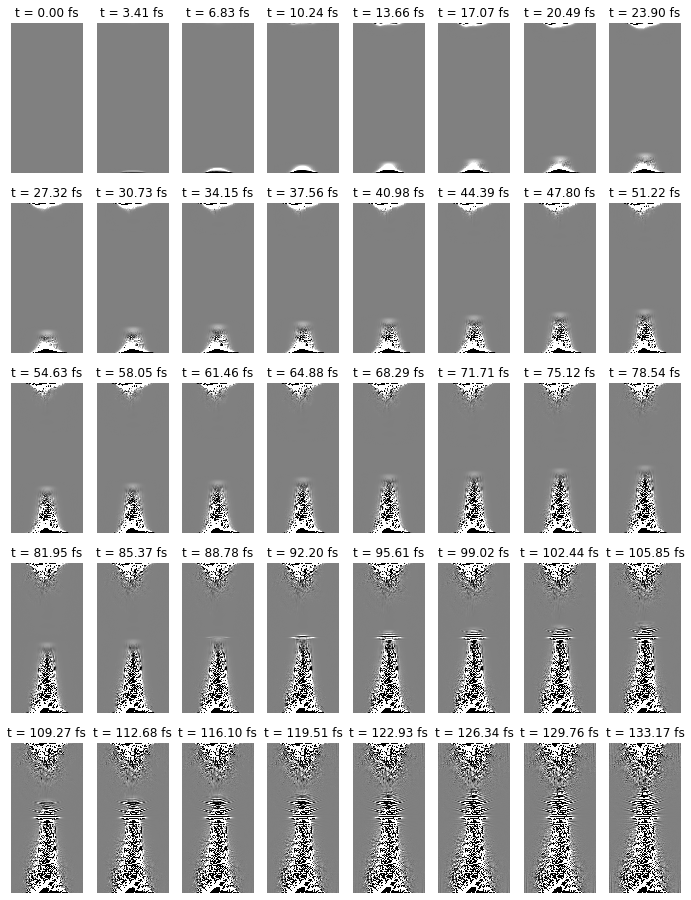

In [342]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( rhops[i].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=0.999, vmax=1.001)
            )
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')

In [352]:
epyz[0].min(), epyz[0].max()

(-1.091928482055664, -0.007628829218447208)

In [356]:
eppzy.min(), eppzy.max()

(-355.7003479003906, 0.0)

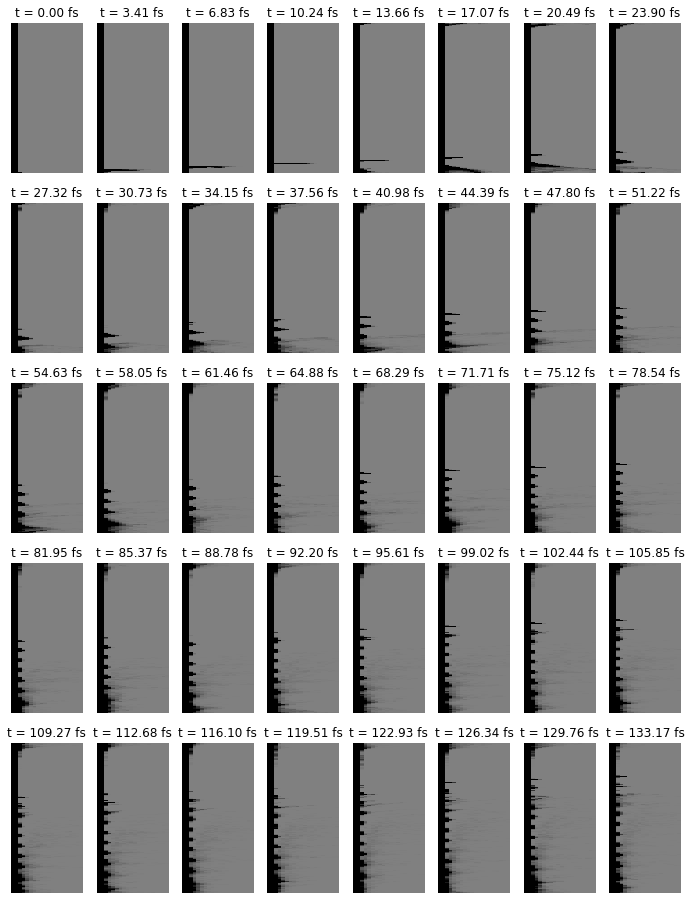

In [365]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( eppzy[i][:20,:].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=-10, vmax=10)
            )
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')

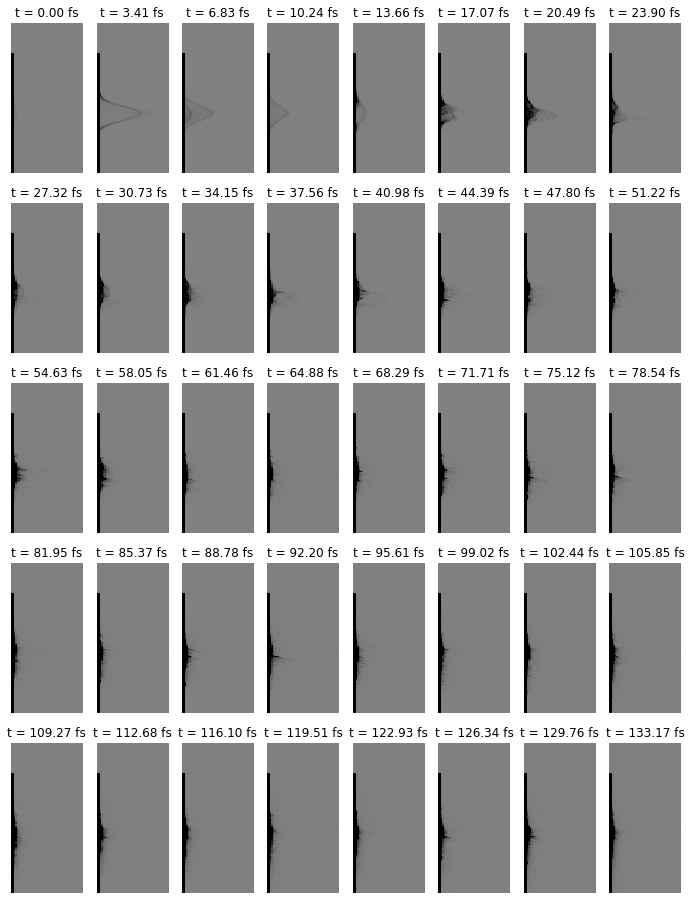

In [368]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( eppzz[i][:50,:].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=-10, vmax=10)
            )
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')

In [370]:
epyz.min(), epyz.max()

(-8.265121459960938, 0.0)

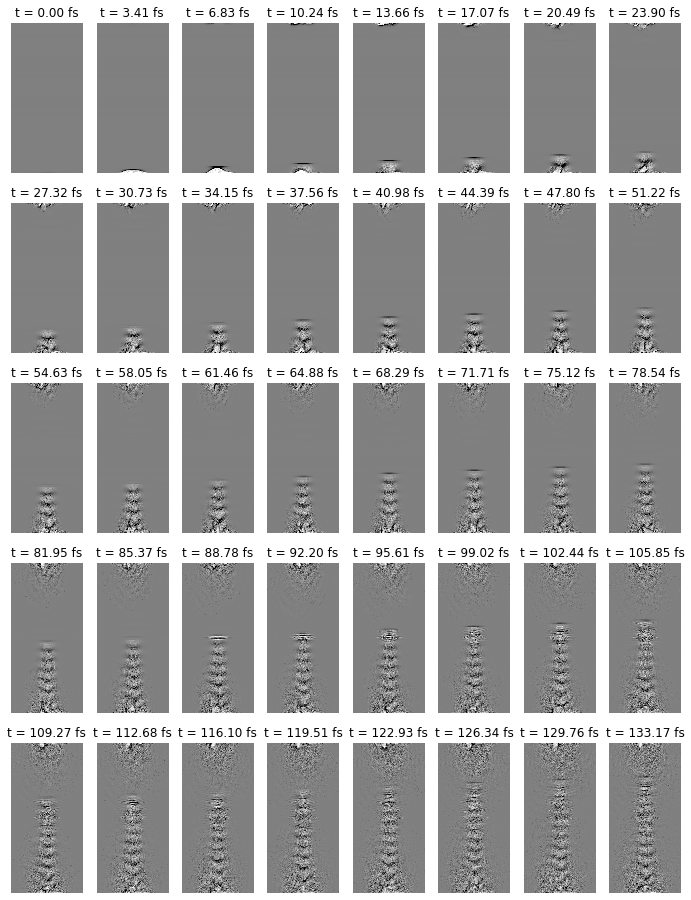

In [372]:
fig, axs = plt.subplots(5,8)
fig.set_size_inches(12,16)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(40):
    row = i//8
    col = i%8
    ax = axs[row,col]
    ax.imshow( epyz[i].T, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect="auto", 
            cmap = 'gray',
            norm=colors.Normalize(vmin=-2, vmax=0)
            )
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")
    ax.axis('off')

In [70]:
def plot_per_time(time):
    boundary = [[0,sim.box[0]],[0,sim.box[1]]]

    plt.imshow( ezs_time[time].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')

    plt.colorbar().set_label('$E_z$')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"Laser Field\nt = {times[time]:.2f} fs")

    plt.show()

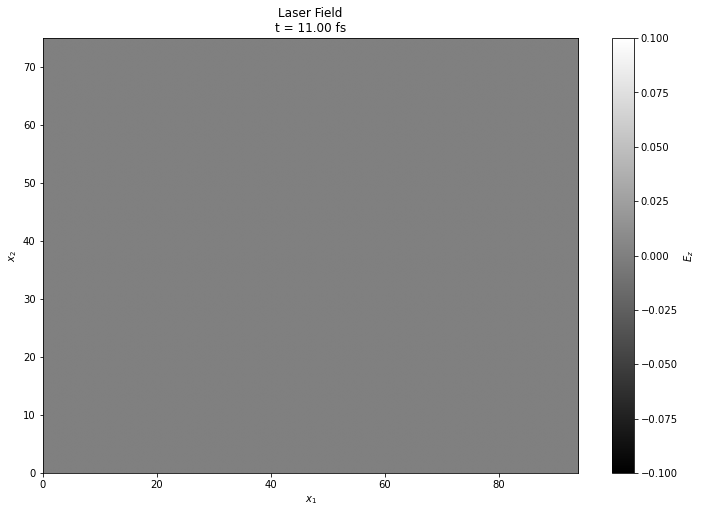

In [73]:
plot_per_time(1)